In [1]:
# file: py_c2bec2d/gpe_xmds.py

import shlex, subprocess
import numpy as np

import matplotlib.pyplot as plt

import h5py

In [7]:
# file: py_c2bec2d/gpe_xmds.py

def run_shell_command(cmdline, output=True):
    print("run shell command: ", cmdline, "\n")
    args = shlex.split(cmdline)
    # let's use the new run command
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    if output:
        print(p.stdout.decode('utf-8'))
        return p.stderr    

In [8]:
run_shell_command('ls', output=False)

run shell command:  ls 



# GP Solution with xmds2

## Generate xmds file with desired number of lattice points, ranges in $x$ and $y$ coordinates, maximum simulation time etc.

In [9]:
# file: py_c2bec2d/gpe_xmds.py

def generate_xmdsfile(xmax=10.0, ymax=10, nlat=128, tmax=1, xmdstol=1.e-8,
                      nsamples1=4, nsamples2=4, args_in_filename="no",
                      xmds_compile="compile_gpe.xmds",
                      xmdstemplate="template_gpe.xmds"):

    # Read in the template file
    with open(xmdstemplate, 'r') as file :
      filedata = file.read()
    
    # Replace the target strings
    filedata = filedata.replace('xmaxVALUE',   str(xmax))
    filedata = filedata.replace('ymaxVALUE',   str(ymax))
    filedata = filedata.replace('nlatVALUE',   str(nlat))
    filedata = filedata.replace('nsamples1VALUE',   str(nsamples1))
    filedata = filedata.replace('nsamples2VALUE',   str(nsamples2))
    filedata = filedata.replace('tmaxVALUE',   str(tmax))
    filedata = filedata.replace('tolVALUE',    str(xmdstol))
    filedata = filedata.replace('argsVALUE',   args_in_filename)

    # Write out the file to be compiledb
    with open(xmds_compile, 'w') as file:
      file.write(filedata)
    
    print("xmds file to compile: "+xmds_compile)

In [10]:
# Simulation parameters
xmax=10
ymax=xmax
nlat=64

In [11]:
generate_xmdsfile(tmax=1, nlat=nlat)

xmds file to compile: compile_gpe.xmds


In [12]:
# file: py_c2bec2d/gpe_xmds.py

def compile_xmds(xmds_compile="compile_gpe.xmds", output=True):
    cmdline  = 'xmds2 '+xmds_compile
    return run_shell_command(cmdline,output=output)

In [13]:
stderr = compile_xmds(output=True)

run shell command:  xmds2 compile_gpe.xmds 

xmds2 version 3.0.0 "Release the Kraken" (r3071)
Copyright 2000-2019 Graham Dennis, Joseph Hope, Mattias Johnsson
                    and the xmds team
Generating source code...
... done
Compiling simulation...
... done. Type './xgpe2d' to run.



## create and save initial wave function 

In [14]:
# file: py_c2bec2d/gpe_xmds.py

def save_real_func_as_h5(xa, ya, sa, Vext, variable_name="Vext0", file_name="func.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name, data=Vext)
    hf.close()
    print("saved file "+file_name)

def save_complex_func_as_h5(xa, ya, sa, phi0, variable_name="phi0", file_name="cfunc.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name+"R", data=phi0.real)
    hf.create_dataset(variable_name+"I", data=phi0.imag)
    hf.close()
    print("saved file "+file_name)

In [78]:
xa = np.linspace(-xmax,xmax,nlat+1)[:-1]
ya = np.linspace(-ymax,ymax,nlat+1)[:-1]
sa = np.array([1, 2])

xx, yy, ss= np.meshgrid(xa,ya,sa,indexing='xy')  ### changed the index by 'xy' from 'ij'

theta = np.arctan2(yy,xx)

r2 = xx**2 + yy**2 
rr = np.sqrt(r2)
σ2 = ss

phi0 = np.exp(-r2/(2*σ2)+1j*ss*theta)+0*1j
norm2 = np.sum(np.abs(phi0)**2,axis=(0,1))*(xa[1]-xa[0])*(ya[1]-ya[0])
#print(norm2)
phi0[:,:,0] = phi0[:,:,0]/np.sqrt(norm2[0])
phi0[:,:,1] = phi0[:,:,1]/np.sqrt(norm2[1])

In [79]:
%matplotlib inline

import matplotlib.pyplot as plt 
plt.style.use(['tableau-colorblind10'])

saved file 2phi0.h5


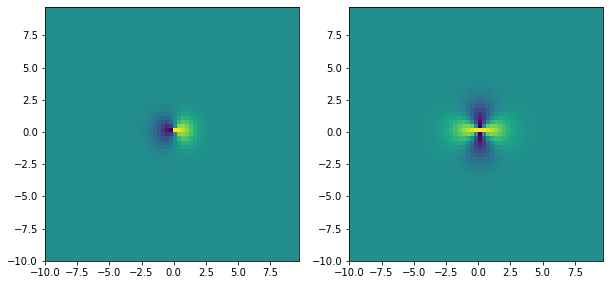

In [80]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

for i in range(2):
    ax[i].pcolor(xa,ya,phi0.real[:,:,i])
    ax[i].set_aspect(1.)
    
save_complex_func_as_h5(xa, ya, sa, phi0, file_name="2phi0.h5")

## create and save external potential

saved file 2Vext.h5


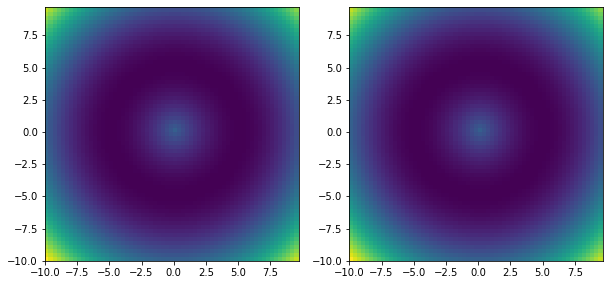

In [81]:
# external potential
r0 = 5
V_Corbino = 0.5*(rr-r0)**2

fig, ax = plt.subplots(1,2,figsize=(10,5))

for i in range(2):
    ax[i].pcolor(xa,ya,V_Corbino[:,:,i])
    ax[i].set_aspect(1.)

save_real_func_as_h5(xa, ya, sa, V_Corbino, file_name="2Vext.h5")

In [82]:
# file: py_c2bec2d/gpe_xmds.py

def run_xmds(args_dict={"r0":0}, exefile="xgpe2d", output=True):
    # run simulation
    # ./xgpe2d --r0=0 etc.
    cmdline  = 'nice -19 ./'+exefile
    for arg in args_dict:
        cmdline+=" --"+arg+"="+str(args_dict[arg])
    
    return run_shell_command(cmdline,output=output)

In [83]:
g0=100
args= {
      "use_phi0"    : 1, 
      "use_Vext0"   : 1, 
      "use_OOmega2" : 1, 
      "r0"          : 5,
      "N1"          : 1.0,
      "N2"          : 1.0,
      "U11"         : g0,
      "U22"         : g0,
      "U12"         : 0.*g0,
      "U21"         : 0.*g0,
      "Omega1"      : 0.01,
      "Omega2"      : 0.
      }

In [84]:
run_xmds(args)

run shell command:  nice -19 ./xgpe2d --use_phi0=1 --use_Vext0=1 --use_OOmega2=1 --r0=5 --N1=1.0 --N2=1.0 --U11=100 --U22=100 --U12=0.0 --U21=0.0 --Omega1=0.01 --Omega2=0.0 

Found enlightenment... (Importing wisdom)
Planning for (x, y) <---> (kx, ky) transform... done.
Planning for (x, y) <---> (kx, ky) transform... done.
Sampled field (for moment group #1) at t = 0.000000e+00
Sampled field (for moment group #2) at t = 0.000000e+00


 Real/Imag. time evolution of a charged two-component BEC: 


Current timestep: 4.006945e-03
Sampled field (for moment group #1) at t = 2.500000e-01
Sampled field (for moment group #2) at t = 2.500000e-01
Current timestep: 5.987358e-03
Sampled field (for moment group #1) at t = 5.000000e-01
Sampled field (for moment group #2) at t = 5.000000e-01
Current timestep: 7.333507e-03
Sampled field (for moment group #1) at t = 7.500000e-01
Sampled field (for moment group #2) at t = 7.500000e-01
Current timestep: 1.092304e-02
Sampled field (for moment group #1) at 

In [85]:
# file: py_c2bec2d/gpe_xmds.py

# pickles xmds output variables as python dictionary
def save_xmds_output(outfile="out_gpe2d", output=True):
   # generate python file to read output data 
    cmdline=('xsil2graphics2 -p '+ outfile+'.xsil')
    run_shell_command(cmdline,output=output)
    
    # get a list of xmds variables
    with open(outfile+".py", 'r') as infile:
        variable_list=[]
        copy = False
        for line in infile:
            if line.strip() == "return None":
                copy = True
            elif line.strip() == "# Write your plotting commands here.":
                copy = False
            elif copy:
                variable_list.append(line.split(' ', 1)[0])
    variable_list=variable_list[1:-1]
    
    str_variable_list=[]
    for var in variable_list:
        str_variable_list.append('"'+var+'"')
        
    #print(str_variable_list)
    
    # save using xmds utils generated python2 and pickle save
    with open(outfile+'.py', "a") as xsilpyfile:
        xsilpyfile.write("var_dict={}\n")
        xsilpyfile.write('for var_name, variable in zip(['+", ".join(str_variable_list)+"],["+", ".join(variable_list)+"]):\n")
        xsilpyfile.write("    var_dict[var_name]=variable\n")
        xsilpyfile.write("import pickle\n")
        xsilpyfile.write("with open('"+outfile+".pkl', 'w') as f:  # Python 3: open(..., 'wb')\n")
        xsilpyfile.write("   pickle.dump(var_dict, f)\n")
    
    # save using system python
    cmdline=('python2 '+ outfile+'.py')
    run_shell_command(cmdline,output=output)

In [86]:
save_xmds_output(outfile="out_gpe2d", output=False)

run shell command:  xsil2graphics2 -p out_gpe2d.xsil 

run shell command:  python2 out_gpe2d.py 



In [87]:
# file: py_c2bec2d/gpe_xmds.py

def get_xmds_output(outfile="out_gpe2d"):
    import pickle
    # Getting back the objects:
    with open(outfile+'.pkl','rb') as f:  # Python 3: open(..., 'rb')
        return pickle.load(f,encoding='latin1')

In [88]:
var_dict = get_xmds_output(outfile="out_gpe2d")

In [89]:
var_dict.keys()

dict_keys(['EEVext_2', 'chem_pot_2', 'LLzR_2', 'EEOmega2_2', 'EEkin_canonical_2', 'dens_1', 'EEtot_2', 'phase_1', 'Nnorm_2', 'EEkin_2', 'x_1', 's_1', 'LLzI_2', 's_2', 'y_1', 'phiR_1', 'phiI_1', 'EEintss_2', 't_2', 'Lz_2', 't_1', 'EEint12_2'])

In [90]:
var_dict["t_1"]

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

In [91]:
yy[0:2,0:2,0]

array([[-10.    , -10.    ],
       [ -9.6875,  -9.6875]])

In [92]:
xx[0,1]-xx[0,0]

array([0.3125, 0.3125])

In [93]:
yy[1,0]-yy[0,0]

array([0.3125, 0.3125])

In [94]:
# file: py_c2bec2d/gpe_xmds.py

def velocity_field(phase,xx,yy,theta):

    dx = xx[0,1]-xx[0,0]
    dy = yy[1,0]-yy[0,0]

    phasex=np.unwrap(phase,axis=1)
    phasey=np.unwrap(phase,axis=0)
    
    gradx = np.gradient (phasex, dx, axis=1)
    grady = np.gradient (phasey, dy, axis=0)

    vr =  gradx*np.cos(theta) + grady*np.sin(theta) 
    vt = -gradx*np.sin(theta) + grady*np.cos(theta) 

    return gradx, grady, vr, vt

In [95]:
# file: py_c2bec2d/gpe_xmds.py

def plot_results(out,title=""):                                                                                                                                                                                                                                              
    
    colors=['blue','green']                                                                                                                                                                                                                                                  
    fig, ax = plt.subplots(2,5,figsize=(24,4*2))
        
    xx, yy = np.meshgrid(out["x_1"],out["y_1"], indexing='xy')  ### changed the intex by 'xy'                                                                                                                                                                                    
    theta = np.arctan2(yy,xx)

    for icomp in range(2):                                                                                                                                                                                                                                                   
        dens=out["dens_1"][-1,:,:,icomp]                                                                                                                                                                                                                                            
        #phase=np.mod(out["phase_1"][-1,:,:,icomp],2*np.pi)#+2*np.pi                                                                                                                                                                                                                  
        phase=out["phase_1"][-1,:,:,icomp]                                                                                                                                                                                                                  
        vx, vy, vr, vt =  velocity_field(phase,xx,yy,theta)                                                                                                                                                                                                                 
                                                                                                                                                                                                                                                                             
        img1=ax[icomp,0].pcolor(xx,yy,dens) # final state                                                                                                                                                                                                    
        fig.colorbar(img1, ax=ax[icomp,0])                                                                                                                                                                                                                                   
                                                                                                                                                                                                                                                                             
        img2=ax[icomp,1].pcolor(xx,yy,phase/(np.pi)) # phase/2*pi                                                                                                                                                                                                          
        cbar2=fig.colorbar(img2, ax=ax[icomp,1],format="%.1g")                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                             
        img3=ax[icomp,2].pcolor(xx,yy,vr*dens)                                                                                                                                                                                                                               
        cbar3=fig.colorbar(img3, ax=ax[icomp,2],format="%.1g")                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                             
        img4=ax[icomp,3].pcolor(xx,yy,vt*dens)                                                                                                                                                                                                                               
        cbar4=fig.colorbar(img4, ax=ax[icomp,3],format="%.1g")                                                                                                                                                                                                               
                                                                                                                                                                                                                                                                             
        ax[icomp,4].plot(out["t_2"], out["Nnorm_2"][:,icomp],'o-', color=colors[icomp], label='norm')                                                                                                                                                                                           
        ax[icomp,4].plot(out["t_2"], out["LLzR_2"][:,icomp],'x--', color=colors[icomp], label='Lz')                                                                                                                                                                                            
                                                                                                                                                                                                                                                                             
    for ix in range(4):                                                                                                                                                                                                                                                      
        ax[0,ix].set_xticklabels([])                                                                                                                                                                                                                                         
        ax[0,ix].set_aspect(1.0)                                                                                                                                                                                                                                             
        ax[1,ix].set_aspect(1.0)                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                             
    for iy in range(1,4):                                                                                                                                                                                                                                                    
        ax[0,iy].set_yticklabels([])                                                                                                                                                                                                                                         
        ax[1,iy].set_yticklabels([])                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                             
    ax[0,4].legend(fontsize=10)                                                                                                                                                                                                                                              
                                                                                                                                                                                                                                                                             
    ax[0,0].set_title("density")                                                                                                                                                                                                                                             
    ax[0,1].set_title("$phase/\pi$")                                                                                                                                                                                                                                       
    ax[0,2].set_title("radial vel.")                                                                                                                                                                                                                                         
    ax[0,3].set_title("angular vel.")                                                                                                                                                                                                                                        
    #ax[0,4].set_title("norm, PS, Lz")                                                                                                                                                                                                                                       
    fig.suptitle(title, fontsize=54)                                                                                                                                                                                                                                         
    fig.tight_layout()                                                                                                                                                                                                                                                       
    fig.subplots_adjust(top=.86)    

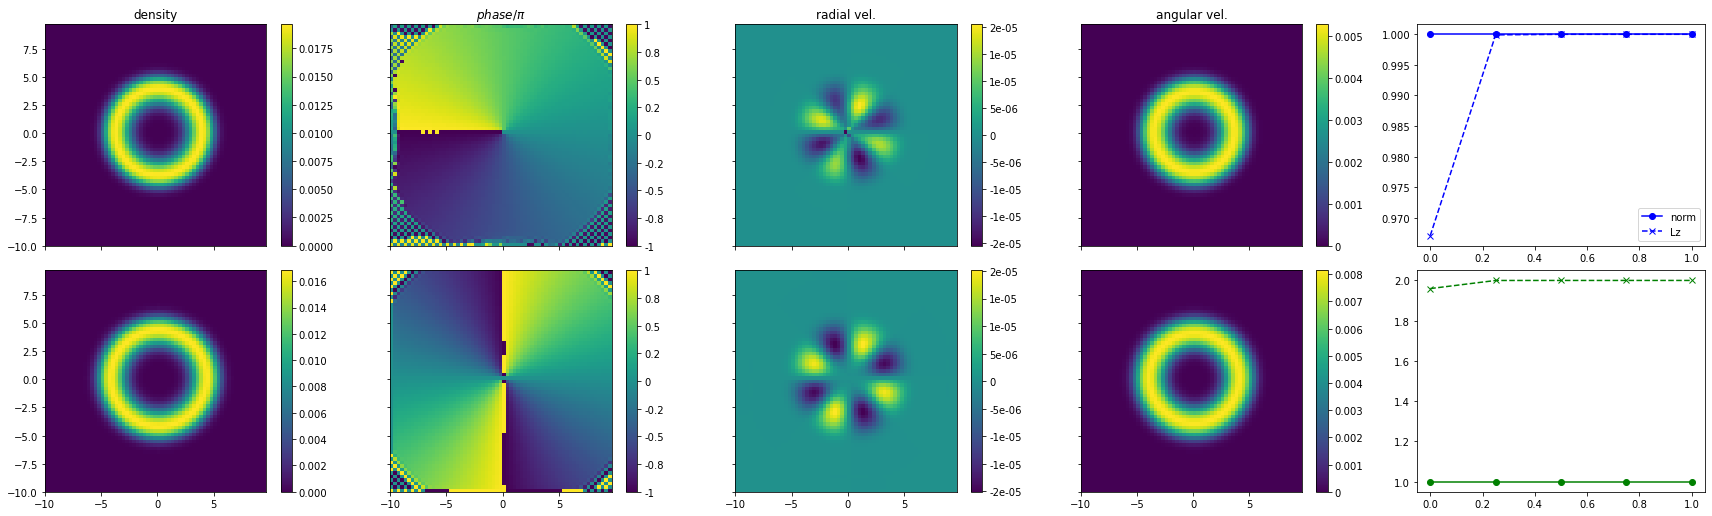

In [96]:
plot_results(var_dict)